In [1]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt

import numpy             as np
import tables            as tb
import seaborn as sns

#import invisible_cities.core.core_functions as coref
#import invisible_cities.core.fit_functions  as fitf

from   scipy.optimize                          import curve_fit
from   scipy                                   import stats

#from   invisible_cities.io.dst_io import df_writer

# Formatting options
pd.options.display.max_columns = None
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Directory to which figures will be stored
#save_dir = "Plots Iniciales"
#ftype = "pdf"
#if(not os.path.isdir(save_dir)):
#    print("Creating directory",save_dir)
#    os.mkdir(save_dir)

In [2]:
evtfnames_data = ["/Users/diego/Desktop/DIEGO/USC/TFG/data/ntuple_combined_7746.h5"]
evtfnames_MC   = ["/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6206.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6207.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6208.h5",]

In [3]:
cdf = None
for ifile,fname in enumerate(evtfnames_MC):

    print("Adding file {} ...".format(fname))

    ftbl = tb.open_file(fname, 'r')
    
    fsummary = ftbl.root.Summary.Events
    fdst = ftbl.root.DST.Events
    ftracks = ftbl.root.Tracking.Tracks

    # Read the tables into DataFrames.
    to_df = pd.DataFrame.from_records
    df_summary = to_df(fsummary.read())
    df_tracks = to_df(ftracks.read())
    df_dst = to_df(fdst.read())
    
    # Drop duplicates in the KDST, selecting the S1 and S2 with highest energy.
    df_dst1 = df_dst.sort_values(['event','S1e','S2e'])[['event','S2e','S1e','nS1','nS2']].drop_duplicates('event',keep='last')
    
    # Drop duplicates in the TDST, selecting the longest tracks.
    df_tracks = df_tracks.sort_values(['event','length','energy']).drop_duplicates('event',keep='last')
    
    # Merge into a single dataframe.
    df_merge = pd.merge(df_summary, df_dst1, on = 'event', how='left')
    df_merge = pd.merge(df_merge, df_tracks, on = 'event', how='left')
    
    # Concatenate with previous runs.
    if(cdf is None):
        cdf = df_merge
    else:
        cdf = cdf.append(df_merge)
        
    ftbl.close()

A_evtnum    = cdf['event'].values
A_maxtrklen = cdf['length'].values
A_maxtrkenergy = cdf['energy'].values
A_ntrks     = cdf['evt_ntrks'].values
A_nhits     = cdf['evt_nhits'].values
A_Ec        = cdf['evt_energy'].values
A_xavg      = cdf['evt_x_avg'].values
A_yavg      = cdf['evt_y_avg'].values
A_zavg      = cdf['evt_z_avg'].values
A_ravg      = cdf['evt_r_avg'].values
A_xmin      = cdf['evt_x_min'].values
A_ymin      = cdf['evt_y_min'].values
A_zmin      = cdf['evt_z_min'].values
A_xmax      = cdf['evt_x_max'].values
A_ymax      = cdf['evt_y_max'].values
A_zmax      = cdf['evt_z_max'].values
A_rmin      = cdf['evt_r_min'].values
A_rmax      = cdf['evt_r_max'].values
A_nS1       = cdf['nS1'].values
A_S2e       = cdf['S2e'].values

print("{} total events".format(len(A_evtnum)))
cdf.head(10)

Adding file /Users/diego/Dropbox/NEXT/ntuple_combined_MC_6206.h5 ...
Adding file /Users/diego/Dropbox/NEXT/ntuple_combined_MC_6207.h5 ...
Adding file /Users/diego/Dropbox/NEXT/ntuple_combined_MC_6208.h5 ...
322327 total events


,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map,S2e,S1e,nS1,nS2,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,1,1.491183,-1.0,1,153,-113.623835,45.844995,198.700846,123.571428,-155.0,15.0,177.125250,79.056942,-75.0,95.0,208.673156,168.077363,False,399937.37500,490.154266,1,1,0,1.491183,110.245795,58,153,1,-155.0,15.0,177.125250,79.056942,-75.0,95.0,208.673156,168.077363,-113.623835,45.844995,198.700846,123.571428,-1.100000e+02,9.000000e+01,177.899203,-80.0,3.000000e+01,207.899203,-75.000000,25.000000,206.110672,-105.0,95.0,178.439502,0.304461,0.105867,0.0,10.0,10.0,10.0
1,2,1.690872,-1.0,2,168,44.702818,154.429392,196.487279,162.069197,5.0,95.0,167.124437,109.772492,75.0,185.0,352.708219,199.624648,False,358848.93750,563.838623,1,2,0,1.523521,72.925287,42,148,2,15.0,135.0,167.124437,145.773797,75.0,185.0,198.729094,199.624648,43.312292,159.510146,179.483658,166.369669,2.000000e+01,1.400000e+02,179.916328,70.0,1.800000e+02,199.916328,15.000000,145.000000,182.542955,75.0,185.0,198.202585,0.415004,0.123652,0.0,10.0,10.0,10.0
2,3,1.454100,-1.0,2,167,17.380662,24.086533,271.829615,32.352240,-5.0,-15.0,251.202844,7.071068,35.0,165.0,296.603531,165.075740,False,409170.59375,510.470215,1,1,0,1.448270,109.746915,37,165,2,-5.0,-15.0,251.202844,7.071068,35.0,85.0,296.603531,88.600226,17.476393,23.533727,271.841606,31.805387,1.000000e+01,-1.000000e+01,253.903187,20.0,8.000000e+01,293.903188,5.000000,-15.000000,254.855618,25.0,85.0,289.735796,0.193550,0.096244,0.0,10.0,10.0,10.0
3,4,1.695938,-1.0,2,170,36.282743,26.266488,243.456945,69.015392,-5.0,-115.0,209.094063,29.154759,165.0,75.0,326.697500,195.576072,False,419710.43750,622.652222,1,2,0,1.474706,82.925287,53,143,2,-5.0,15.0,209.094063,29.154759,55.0,75.0,250.593844,75.166482,19.384727,45.306969,231.316619,52.388545,1.000000e+01,6.000000e+01,252.895781,60.0,2.000000e+01,222.895781,5.000000,65.000000,248.799813,55.0,25.0,226.814094,0.583341,0.178080,0.0,10.0,10.0,10.0
4,5,1.499156,-1.0,1,135,-142.819879,5.633705,190.563333,143.303047,-165.0,-25.0,180.146500,115.974135,-115.0,25.0,207.875656,165.680415,False,394655.78125,425.728394,1,1,0,1.499156,44.142136,25,132,1,-165.0,-15.0,180.146500,115.974135,-115.0,25.0,207.875656,165.075740,-142.804813,5.664735,190.554229,143.284756,-1.600000e+02,-1.776357e-15,184.011078,-120.0,1.000000e+01,184.011078,-165.000000,-2.641590,182.475908,-115.0,15.0,187.356353,0.380602,0.233692,0.0,10.0,10.0,10.0
5,6,1.521329,-1.0,1,136,-87.650980,150.675900,295.752377,175.009691,-115.0,135.0,267.101812,149.833241,-45.0,175.0,332.806750,195.576072,False,315667.71875,624.252686,1,1,0,1.521329,87.067423,39,135,1,-115.0,135.0,267.101812,149.833241,-55.0,175.0,332.806750,195.576072,-87.686408,150.675900,295.752377,175.019961,-1.100000e+02,1.500000e+02,269.954281,-60.0,1.700000e+02,329.954281,-115.000000,145.000000,271.247362,-55.0,175.0,332.427351,0.398977,0.128317,0.0,10.0,10.0,10.0
6,7,1.689332,-1.0,1,164,-32.128175,14.058594,148.289215,40.096504,-55.0,-15.0,118.136500,15.811388,-5.0,65.0,203.705312,79.056942,False,501236.40625,447.781403,1,1,0,1.689332,127.566304,46,163,1,-55.0,-15.0,118.136500,15.811388,-5.0,65.0,203.705312,79.056942,-32.092280,14.058594,148.289215,40.072389,-4.000000e+01,-1.000000e+01,140.920906,-40.0,6.000000e+01,200.920906,-45.000000,-15.000000,140.745268,-45.0,65.0,202.884699,0.440450,0.132779,0.0,10.0,10.0,10.0
7,8,1.445031,-1.0,1,123,-87.123203,-3.437025,422.807476,87.674872,-105.0,-25.0,406.162781,65.192024,-65.0,25.0,443.704250,106.066017,False,369270.28125,625.633728,1,1,0,1.445031,45.604779,25,120,1,-105.0,-25.0,406.162781,65.192024,-65.0,

In [9]:
#ESTO NO ES FUNCIONAL PARA ARRAYS DE MUCHÍSIMOS VALORES


x = [1,2,3,4,5,6,7,8,9,10]
y = [2,3,4,1,5,4,7,5,6,3]


def Varianza_Lista(x):
    v = []
    for i,k in zip(y[0::2], y[1::2]):
        v.append(np.var([i,k]))
    return v

def Bins(x):
    b = []
    for i,k,j in zip(x[0::3], x[1::3], x[2::3]):
        b.append(np.mean([i,k,j]))
    return b

def Y_Mean(x):
    m = []
    for i,k in zip(y[0::2], y[1::2]):
        m.append(np.mean([i,k]))
    return m

#plt.scatter(Bins(x),Y_Mean(y))
#plt.errorbar(Bins(x),Y_Mean(y), yerr=Varianza_Lista(y), linestyle='None')

print(Varianza_Lista(y))
print(Bins(x))
print(Y_Mean(y))

[0.25, 2.25, 0.25, 1.0, 2.25]
[2.0, 5.0, 8.0]
[2.5, 2.5, 4.5, 6.0, 4.5]


Text(0.5, 0, 'nS2')

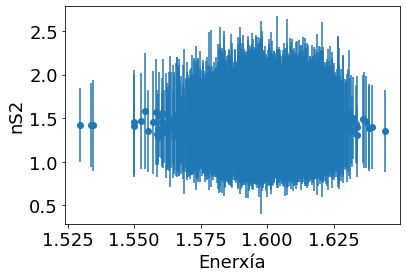

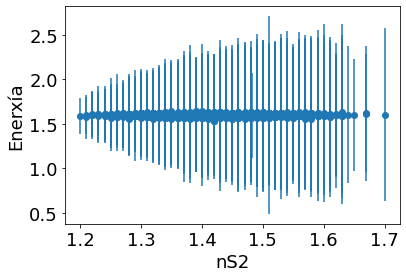

In [62]:
#CASI FUNCIONA, PERO TENDRÍA QUE TENER EL EJE DE LAS X ORDENADOR DE MENOR A MAYOR Y AL ESTAR LLENO DE NAN 
#NO FUNCIONA EL SORT. SI QUITO LOS NAN, len(x) != len(y)


def media(lst):
    big_list = lst
    def split_list(x):
        return[big_list[i:i+x] for i in range(0, len(big_list), x)]
    x = split_list(100)

    y = []
    for i in range(len(x)):
        y.append(np.mean(x[i]))
    return y


def varianza(lst):
    big_list = lst
    def split_list(x):
        return[big_list[i:i+x] for i in range(0, len(big_list), x)]
    x = split_list(100)

    y = []
    for i in range(len(x)):
        y.append(np.var(x[i]))
    return y

#print(media([1,2,3,4,5,6,7,8,9,10]))
#print(sorted(cdf.evt_energy))
#print(varianza([1,2,3,4,5,6,7,8,9,10]))

#z = [x for x in cdf.evt_energy if str(x) != 'nan']
#k = [x for x in cdf.nS2 if str(x) != 'nan']
x = media(cdf.evt_energy)
y = media(cdf.nS2)
error = varianza(cdf.nS2)


plt.figure(1)

plt.scatter(x, y)
plt.errorbar(x, y, yerr=error, linestyle='None')
#plt.xticks([1.601, 1.602])
#plt.xlim(1.601, 1.602)
plt.xlabel('Enerxía')
plt.ylabel('nS2')


x1 = media(cdf.nS2)
y1 = media(cdf.evt_energy)

plt.figure(2)

plt.scatter(x1, y1)
plt.errorbar(x1, y1, yerr=error, linestyle='None')
#plt.xticks([1.4, 1.5, 1.6, 1.7])
#plt.xlim(1.4, 1.42)
plt.ylabel('Enerxía')
plt.xlabel('nS2')


In [101]:
y = sorted(cdf.evt_energy)
x = [x for x in cdf.evt_energy if str(x) != 'nan']
#print(sorted(x[0:30000]))

In [63]:
print(media(cdf.evt_energy))

[1.612552270275532, 1.5964838058561766, 1.583126915028547, 1.6223978932931744, 1.6099380197296471, 1.6029878233098884, 1.606209625218243, 1.6018252215897124, 1.6204548007471193, 1.612891312406906, 1.606670853542238, 1.6233569858719288, 1.6061854960431488, 1.6085043467765598, 1.6007075154810795, 1.5798113146622945, 1.588651432286313, 1.6005340933389867, 1.6028776128949085, 1.6128695036631153, 1.5870340986897102, 1.5940723972125952, 1.6119912843557342, 1.6000812265447242, 1.5985564011887026, 1.5851872275993484, 1.6040735354569404, 1.5929501376340003, 1.6050135101872585, 1.5938617782085114, 1.5966272894644336, 1.617837869748932, 1.60248756425229, 1.5978897937629495, 1.6058012835584197, 1.5866699879021688, 1.6109949355846873, 1.6022899540328075, 1.5851360212846295, 1.5866108895149609, 1.6119082103173497, 1.588757976439502, 1.5983587275004374, 1.6062833422268208, 1.6004894077921077, 1.5896416577424217, 1.5969234334694278, 1.5898818782794415, 1.6204968959743793, 1.6273223070193752, 1.5966179